Data catalog information:

http://legacysurvey.org/dr7/files/#sweep-catalogs

http://www.ucolick.org/~kbundy/massivegalaxies/s82-mgc-catalogs.html

Download files:

https://pitt.box.com/s/5fkrrjrhn2ebxakojex3vsxlcqihezlf

In [1]:
from __future__ import division, print_function
import os, sys, warnings
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table

In [2]:
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
cat_dir = '../downloads/'

# DECaLS catalog
decals = Table.read(cat_dir+'decals-dr7.1-UKBOSS_best_ukwide_v5_2-02jun2015-match.fits')
# matched best_ukwide catalog
mgc = Table.read(cat_dir+'UKBOSS_best_ukwide_v5_2-02jun2015-match.fits')

decals["DCHISQ_EXP"] = decals["DCHISQ"][:,2]
decals["DCHISQ_DEV"] = decals["DCHISQ"][:,3]
del decals["DCHISQ"]
decals = decals.to_pandas()

del mgc["ABSMAG_BEST"]
mgc = mgc.to_pandas()

In [4]:
decals.columns.values

array(['RELEASE', 'BRICKID', 'BRICKNAME', 'OBJID', 'TYPE', 'RA', 'DEC',
       'RA_IVAR', 'DEC_IVAR', 'EBV', 'FLUX_U', 'FLUX_G', 'FLUX_R',
       'FLUX_I', 'FLUX_Z', 'FLUX_Y', 'FLUX_W1', 'FLUX_W2', 'FLUX_W3',
       'FLUX_W4', 'FLUX_IVAR_U', 'FLUX_IVAR_G', 'FLUX_IVAR_R',
       'FLUX_IVAR_I', 'FLUX_IVAR_Z', 'FLUX_IVAR_Y', 'FLUX_IVAR_W1',
       'FLUX_IVAR_W2', 'FLUX_IVAR_W3', 'FLUX_IVAR_W4',
       'MW_TRANSMISSION_U', 'MW_TRANSMISSION_G', 'MW_TRANSMISSION_R',
       'MW_TRANSMISSION_I', 'MW_TRANSMISSION_Z', 'MW_TRANSMISSION_Y',
       'MW_TRANSMISSION_W1', 'MW_TRANSMISSION_W2', 'MW_TRANSMISSION_W3',
       'MW_TRANSMISSION_W4', 'NOBS_U', 'NOBS_G', 'NOBS_R', 'NOBS_I',
       'NOBS_Z', 'NOBS_Y', 'NOBS_W1', 'NOBS_W2', 'NOBS_W3', 'NOBS_W4',
       'RCHISQ_U', 'RCHISQ_G', 'RCHISQ_R', 'RCHISQ_I', 'RCHISQ_Z',
       'RCHISQ_Y', 'RCHISQ_W1', 'RCHISQ_W2', 'RCHISQ_W3', 'RCHISQ_W4',
       'FRACFLUX_U', 'FRACFLUX_G', 'FRACFLUX_R', 'FRACFLUX_I',
       'FRACFLUX_Z', 'FRACFLUX_Y', 'FRACFLUX_W1', '

In [5]:
decals[:10]

,RELEASE,BRICKID,BRICKNAME,OBJID,TYPE,RA,DEC,RA_IVAR,DEC_IVAR,EBV,...,PARALLAX,PARALLAX_IVAR,PMRA,PMRA_IVAR,PMDEC,PMDEC_IVAR,BRIGHTSTARINBLOB,radius,DCHISQ_EXP,DCHISQ_DEV
0,7000,324436,b'3171m012',5791,b'DEV',317.234801,-1.185925,9.452480e+11,8.471774e+11,0.070425,...,0.0,0.0,0.0,0.0,0.0,0.0,False,0.802593,52658.570312,51871.687500
1,7000,324436,b'3171m012',6502,b'REX',317.217667,-1.163788,8.591536e+11,8.835868e+11,0.070258,...,0.0,0.0,0.0,0.0,0.0,0.0,False,0.366664,41688.625000,41703.535156
2,7000,324436,b'3171m012',6503,b'DEV',317.217366,-1.161614,1.182528e+11,1.026327e+11,0.070375,...,0.0,0.0,0.0,0.0,0.0,0.0,False,0.662362,5325.573242,5311.693359
3,7000,325876,b'3171m010',1215,b'REX',317.240314,-1.086993,4.856329e+11,5.034479e+11,0.073530,...,0.0,0.0,0.0,0.0,0.0,0.0,False,0.505753,35132.785156,35483.109375
4,7000,325877,b'3173m010',77,b'REX',317.256512,-1.122673,2.727324e+12,2.598507e+12,0.074802,...,0.0,0.0,0.0,0.0,0.0,0.0,False,0.216932,94991.914062,94946.914062
5,7000,324437,b'3173m012',5734,b'DEV',317.255462,-1.216605,7.869377e+11,6.406463e+11,0.070250,...,0.0,0.0,0.0,0.0,0.0,0.0,False,0.862751,40522.945312,40018.781250
6,7000,324437,b'3173m012',8128,b'EXP',317.252056,-1.145078,4.027163e+11,5.437234e+11,0.074107,...,0.0,0.0,0.0,0.0,0.0,0.0,False,0.980788,50196.257812,51282.718750
7,7000,324436,b'3171m012',5647,b'EXP',317.227749,-1.186814,9.799458e+11,2.267557e+11,0.069774,...,0.0,0.0,0.0,0.0,0.0,0.0,False,1.927214,75163.531250,76647.710938
8,7000,324437,b'3173m012',8129,b'REX',317.255397,-1.142646,6.120451e+11,6.041262e+11,0.074434,...,0.0,0.0,0.0,0.0,0.0,0.0,False,0.381396,29119.560547,28978.773438
9,7000,325877,b'3173m010',93,b'EXP',317.256760,-1.119121,9.630834e+11,1.021497e+12,0.074830,...,0.0,0.0,0.0,0.0,0.0,0.0,False,1.151800,115752.984375,120707.335938


In [41]:
mgc[:10]

,OBJID,RA,DEC,ORIGIN_BEST,ZBEST,ZPERT,MASS_IR_BEST,MASSERR_IR_BEST,MASS_IR_PERT,MASS_OPT_BEST,MASSERR_OPT_BEST,MASS_OPT_PERT,B1000_IR_BEST,B300_IR_BEST,KCOR_MASS_BEST,SIGMAZ_REIS,SIGMAZ_RM,SIGMAZ_ZRED,SIGMAZ_BEST,LUMERR_DEX
0,8647474690315780209,317.234824,-1.185931,2,0.416651,0.364703,11.013946,0.061972,10.913042,10.988556,0.089489,10.900223,0.003077,6.536538e-10,10.652373,0.033220,-1.0,0.022846,0.022846,0.026535
1,8647474690315780138,317.217690,-1.163792,1,0.552395,0.554437,11.096850,0.066153,11.077892,11.168348,0.085895,11.208653,0.061571,1.059387e-02,10.733143,0.038194,-1.0,-1.000000,0.038194,0.028937
2,8647474690315780139,317.217362,-1.161628,1,0.642978,0.631134,11.188470,0.083909,11.315879,10.820254,0.099640,10.813088,0.359583,1.079187e-09,10.577702,0.053483,-1.0,-1.000000,0.053483,0.051569
3,8647474690315780240,317.240315,-1.086981,1,0.265760,0.262863,10.233574,0.075196,10.233574,10.174479,0.074147,10.174479,0.036789,2.651124e-02,9.874898,0.031936,-1.0,-1.000000,0.031936,0.046292
4,8647474690315780351,317.256521,-1.122673,1,0.290491,0.341647,10.179104,0.250003,10.179104,10.408883,0.203393,10.408883,0.044813,1.024154e-04,10.126888,0.033331,-1.0,-1.000000,0.033331,0.028981
5,8647474690315780409,317.255532,-1.216625,4,0.555063,0.593337,11.340985,0.064085,11.524275,11.390354,0.079572,11.514921,0.008000,3.114222e-07,11.007383,0.036772,-1.0,0.027502,0.000000,0.029893
6,8647474690315780321,317.252071,-1.145078,1,0.405976,0.423492,10.925607,0.083098,11.082236,10.993724,0.082785,10.862252,0.015740,5.147419e-05,10.620180,0.030760,-1.0,-1.000000,0.030760,0.034194
7,8647474690315780170,317.227768,-1.186819,1,0.372871,0.449275,11.083385,0.068688,11.201436,11.117306,0.074297,11.318125,0.133367,5.033607e-03,10.780586,0.026498,-1.0,-1.000000,0.026498,0.021186
8,8647474690315780377,317.255402,-1.142649,4,0.408806,0.381742,10.806005,0.086887,10.813426,10.813448,0.086705,10.797684,0.006720,1.884069e-06,10.494872,0.032524,-1.0,-1.000000,0.000000,0.041538
9,8647474690315780339,317.256754,-1.119114,1,0.285446,0.322537,10.290593,0.096100,10.290593,10.314714,0.076034,10.314714,0.138001,5.167416e-02,10.085320,0.033075,-1.0,-1.000000,0.033075,0.045561


In [6]:
# Apply extinction correction for DECaLS
decals['FLUX_G'] = decals['FLUX_G']/decals['MW_TRANSMISSION_G']
decals['FLUX_R'] = decals['FLUX_R']/decals['MW_TRANSMISSION_R']
decals['FLUX_Z'] = decals['FLUX_Z']/decals['MW_TRANSMISSION_Z']
decals['FLUX_W1'] = decals['FLUX_W1']/decals['MW_TRANSMISSION_W1']
decals['FLUX_W2'] = decals['FLUX_W2']/decals['MW_TRANSMISSION_W2']

# Compute extinction-corrected magnitudes and errors for DECaLS
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    decals['gmag'] = 22.5 - 2.5*np.log10(decals['FLUX_G'])
    decals['rmag'] = 22.5 - 2.5*np.log10(decals['FLUX_R'])
    decals['zmag'] = 22.5 - 2.5*np.log10(decals['FLUX_Z'])
    decals['w1mag'] = 22.5 - 2.5*np.log10(decals['FLUX_W1'])
    decals['w2mag'] = 22.5 - 2.5*np.log10(decals['FLUX_W2'])
    decals['gmagerr'] = 1/np.sqrt(decals['FLUX_IVAR_G'])/decals['FLUX_G']
    decals['rmagerr'] = 1/np.sqrt(decals['FLUX_IVAR_R'])/decals['FLUX_R']
    decals['zmagerr'] = 1/np.sqrt(decals['FLUX_IVAR_Z'])/decals['FLUX_Z']
    decals['w1magerr'] = 1/np.sqrt(decals['FLUX_IVAR_W1'])/decals['FLUX_W1']
    decals['w2magerr'] = 1/np.sqrt(decals['FLUX_IVAR_W2'])/decals['FLUX_W2']
    
# Restrict to DECaLS objects with 2+ exposures in grz bands
mask = (decals['NOBS_G']>=2) & (decals['NOBS_R']>=2) & (decals['NOBS_Z']>=2)
print(np.sum(~mask)/len(mask))
decals = decals[mask]
mgc = mgc[mask]

# Require valid grzW1W2 photometry
mask = np.isfinite(decals['gmag']) & np.isfinite(decals['rmag']) & np.isfinite(decals['zmag']) & \
        np.isfinite(decals['w1mag']) & np.isfinite(decals['w2mag'])
print(np.sum(~mask)/len(mask))
decals = decals[mask]
mgc = mgc[mask]

0.006582100458056051
0.00738496946161892


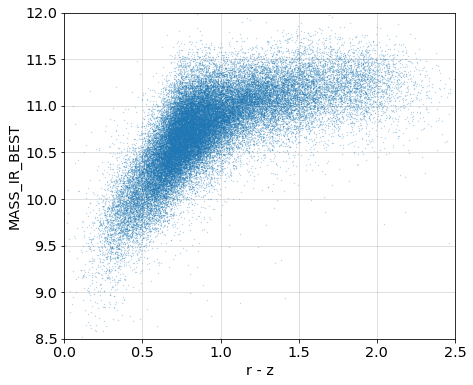

In [7]:
# Stellar mass vs r-z color
plt.figure(figsize=(7, 6))
plt.plot((decals['rmag']-decals['zmag'])[::10], (mgc['MASS_IR_BEST'])[::10], '.', markersize=0.5, alpha=0.5)
plt.xlabel('r - z')
plt.ylabel('MASS_IR_BEST')
plt.grid(alpha=0.5)
plt.axis([0, 2.5, 8.5, 12])
plt.show()

__Some derived morphological parameters:__

In [8]:
# ratio between semi-minor axis and semi-major axis
# See http://legacysurvey.org/dr7/catalogs/#ellipticities
e = np.zeros(len(decals)) # the e parameter is zero for circularly symmetric profiles (PSF and SIMP)
mask = (decals['TYPE']=='EXP') | (decals['TYPE']=='EXP ')
e[mask] = (np.sqrt(decals['SHAPEEXP_E1']**2+decals['SHAPEEXP_E2']**2))[mask]
mask = (decals['TYPE']=='DEV') | (decals['TYPE']=='DEV ')
e[mask] = (np.sqrt(decals['SHAPEDEV_E1']**2+decals['SHAPEDEV_E2']**2))[mask]
mask = (decals['TYPE']=='COMP')
e[mask] = ((1-decals['FRACDEV']) * np.sqrt(decals['SHAPEEXP_E1']**2+decals['SHAPEEXP_E2']**2) \
          + decals['FRACDEV'] * np.sqrt(decals['SHAPEDEV_E1']**2+decals['SHAPEDEV_E2']**2))[mask]
q = (1-e)/(1+e)

# shape probability (definition of shape probability in Soo et al. 2017)
# this parameter characterizes how well an object is fit by exponential profile vs de Vaucouleurs profile
p = np.ones(len(decals))*0.5
# DCHISQ[:, 2] is DCHISQ_EXP; DCHISQ[:, 3] is DCHISQ_DEV
mask_chisq = (decals['DCHISQ_DEV']>0) & (decals['DCHISQ_EXP']>0)
p[mask_chisq] = decals['DCHISQ_DEV'][mask_chisq]/(decals['DCHISQ_DEV']+decals['DCHISQ_EXP'])[mask_chisq]

decals['q'] = q
decals['p'] = p

In [40]:
((p > 0.5) == (decals["TYPE"] == b"EXP")).sum() / len(decals)

0.851339184338535